In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

def consumption(c,we,rest,gamma,v,phi,tauc,taun):
    return (1 + tauc) * c - (1 - taun) * we * ((1 - taun) * we / ((1 + tauc) * phi * c ** gamma)) ** (1/v) - rest

def household_guess(a_grid,e_grid,i,w,gamma,T,taun):
    wel = (1 + i) * a_grid[np.newaxis,:] + (1 - taun) * w * e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1 + i) * (wel * 0.1) ** (-gamma)
    return V_prime

In [2]:
@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,e_grid,i,w,T,beta,gamma,v,phi,tauc,taun):

    we = w * e_grid

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t
    n_prime = ((1 - taun) * we[:,np.newaxis] / ((1 + tauc) * phi * c_prime ** gamma)) ** (1/v)

    new_grid = ((1 + tauc) * c_prime + a_grid[np.newaxis,:] - (1 - taun) * we[:,np.newaxis] * n_prime 
                - T[:,np.newaxis])
    wel = (1 + i) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + (1 - taun) * we[:,np.newaxis] * n + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + i) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = wel[indexes_asset[1]] - a_grid[0] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],
                                                                 rest,gamma,v,phi,tauc,taun),aa,bb)
        n[indexes_asset] = ((1 - taun) * we[indexes_asset[0]] 
                            / ((1 + tauc) * phi * c[indexes_asset] ** gamma)) ** (1/v)
        V_prime[indexes_asset] = (1 + i) * (c[indexes_asset]) ** (-gamma)

    return V_prime,a,c,n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

household_inp = household.add_hetinputs([make_grid,transfers])

print(household_inp)
print(f'Inputs: {household_inp.inputs}')

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'i', 'w', 'T', 'beta', 'gamma', 'v', 'phi', 'tauc', 'taun', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']
<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['i', 'w', 'beta', 'gamma', 'v', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['i', 'w', 'beta', 'gamma', 'v', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [3]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi_pi):
    i = rstar + phi_pi * pi
    r = (1 + i(-1)) / (1 + pi) - 1
    return r, i

@simple
def fiscal(i, Transfer, B, C, L, tauc, taun, w):
    govt_res = Transfer + (1 + i) * B(-1) - tauc * C - taun * w * L - B
    deficit = Transfer - tauc * C - taun * w * L # primary deficit
    return govt_res, deficit

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

In [17]:
blocks_ss = [hh_ext, firm, monetary,fiscal, nkpc_ss, mkt_clearing]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']
Outputs: ['A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'govt_res', 'deficit', 'w', 'asset_mkt', 'labor_mkt', 'goods_mkt']


In [23]:
calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.15, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0, 
               'tauc': 0.1, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'phi': 0.8, 'Transfer': 0.05}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

In [24]:
# Show steady state
eps = ss0['mu'] / (ss0['mu'] - 1)
print("PARAMETERS")
print(f"Discount factor:         {ss0['beta']: .3}", f"     Intertemporal elasticity: {ss0['gamma']}")
print(f"Labor supply elasticity:  {1 / ss0['v']}", f"       Labor disutility:        {ss0['phi']: .3}")
print(f"Goods substitutability:  {eps : .3}", f"       Markup:                  {ss0['mu']: .3}")
print(f"Phillips curve slope:    {ss0['kappa']: .3}", f"       Taylor inflation:        {ss0['phi_pi']: .3}")
print(f"Consumption tax rate:    {ss0['tauc']: .3}", f"       Labor tax rate:          {ss0['taun']: .3}")

print()
print("STEADY STATE")
print(f"Output:                  {ss0['N'] * ss0['Z']: .3}", f"     Government debt:         {ss0['A']: .3}")
print(f"Hours:                   {ss0['N']: .3}", f"     Transfers:               {ss0['Transfer']: .3}")
print(f"Consumption:             {ss0['C']: .3}", f"       Dividends:               {ss0['Div']: .3}")
print(f"Wage:                    {ss0['w']: .3}", f"     Marginal cost:           {1 / ss0['mu']: .3}")
print(f"Inflation:               {ss0['pi']: .3}", f"       Consumption tax revenue: {ss0['tauc']*ss0['C']: .3}")
print(f"Nominal interest rate:   {ss0['r']: .3}", f"     Labor tax revenue:       {ss0['taun']*ss0['N']*ss0['w']: .3}")  
print(f"Real interest rate:      {ss0['r']: .3}", f"     Debt servicing cost:     {ss0['r'] * ss0['A']: .3}")

print()
print("MARKET CLEARING")
print(f"Bond market:             {ss0['asset_mkt']: 0.1e}", f"   Labor market:            {ss0['labor_mkt']: 0.1e}")
print(f"Goods market (resid):    {ss0['goods_mkt']: 0.1e}", f"   Government budget:       {ss0['govt_res']: 0.1e}",)


PARAMETERS
Discount factor:          0.988      Intertemporal elasticity: 1.0
Labor supply elasticity:  0.5        Labor disutility:         0.779
Goods substitutability:   6.0        Markup:                   1.2
Phillips curve slope:     0.15        Taylor inflation:         0.0
Consumption tax rate:     0.1        Labor tax rate:           0.0

STEADY STATE
Output:                   0.971      Government debt:          6.0
Hours:                    0.971      Transfers:                0.07
Consumption:              1.0        Dividends:                0.167
Wage:                     0.833      Marginal cost:            0.833
Inflation:                0.0        Consumption tax revenue:  0.1
Nominal interest rate:    0.005      Labor tax revenue:        0.0
Real interest rate:       0.005      Debt servicing cost:      0.03

MARKET CLEARING
Bond market:             -3.3e-12    Labor market:             1.4e-13
Goods market (resid):    -4.9e-09    Government budget:        4.0e-14


In [25]:
#plt.plot(ss0.internals['household']['a_grid'], ss0.internals['household']['n'].T)
#plt.xlabel('Assets'), plt.ylabel('Labor supply')
#plt.show()

In [26]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'firm'>
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'mkt_clearing'>


In [27]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [28]:
T = 300
exogenous = ['rstar', 'Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'B', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'govt_res', 'deficit', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Transfer', 'Z', 'tauc']>


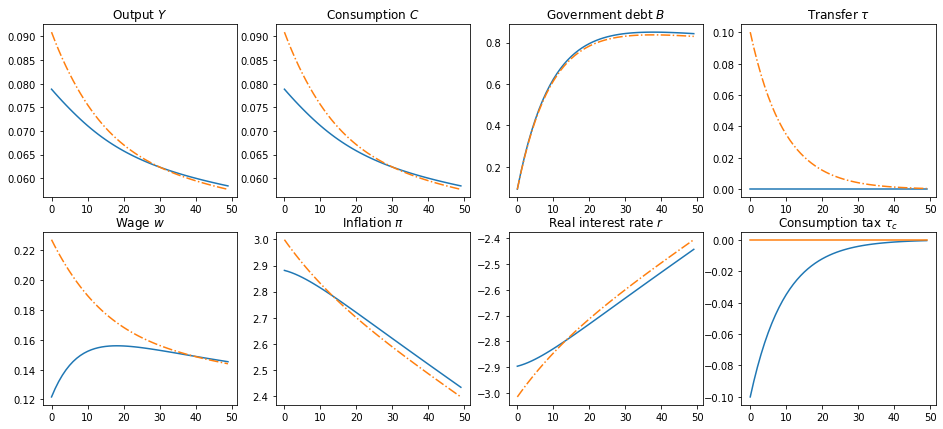

In [29]:
# Impulse response functions
rhos = 0.9
drstar = -0.2 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.1* rhos ** (np.arange(T)[:, np.newaxis])
dtauc = - 0.1 * rhos ** (np.arange(T)[:, np.newaxis])

dY_r = G['Y']['rstar'] @ drstar
dC_r = G['C']['rstar'] @ drstar
dN_r = G['L']['rstar'] @ drstar
dB_r = G['A']['rstar'] @ drstar
dw_r = G['w']['rstar'] @ drstar
dpi_r = G['pi']['rstar'] @ drstar
dr_r = G['r']['rstar'] @ drstar
di_r = G['i']['rstar'] @ drstar
#dT_r = G['Transfer']['rstar'] @ drstar

dY_t = G['Y']['Transfer'] @ dtstar
dC_t = G['C']['Transfer'] @ dtstar
dN_t = G['L']['Transfer'] @ dtstar
dB_t = G['A']['Transfer'] @ dtstar
dD_t = G['deficit']['Transfer'] @ dtstar
dw_t = G['w']['Transfer'] @ dtstar
dpi_t = G['pi']['Transfer'] @ dtstar
dr_t = G['r']['Transfer'] @ dtstar
#dit = G['i']['Transfer'] @ dtstar

dY_c = G['Y']['tauc'] @ dtauc
dC_c = G['C']['tauc'] @ dtauc
dN_c = G['L']['tauc'] @ dtauc
dB_c = G['A']['tauc'] @ dtauc
dD_c = G['deficit']['tauc'] @ dtauc
dw_c = G['w']['tauc'] @ dtauc
dpi_c = G['pi']['tauc'] @ dtauc
dr_c = G['r']['tauc'] @ dtauc
#dic = G['i']['tauc'] @ dtauc

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)

ax[0, 0].set_title(r'Output $Y$')
#l1, = ax[0, 0].plot(dY_r[:50, :])
l1, = ax[0, 0].plot(dY_c[:50, :])
l2, = ax[0, 0].plot(dY_t[:50, :],'-.')

ax[0, 1].set_title(r'Consumption $C$')
#ax[0, 1].plot(dC_r[:50, :])
ax[0, 1].plot(dC_c[:50, :])
ax[0, 1].plot(dC_t[:50, :],'-.')

ax[0, 2].set_title(r'Government debt $B$')
#ax[0, 2].plot(dB_r[:50, :])
ax[0, 2].plot(dB_c[:50, :])
ax[0, 2].plot(dB_t[:50, :],'-.')

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dtstar[:50],'-.')

ax[1, 0].set_title(r'Wage $w$')
#ax[1, 0].plot(dw_r[:50, :])
ax[1, 0].plot(dw_c[:50, :])
ax[1, 0].plot(dw_t[:50, :],'-.')

ax[1, 1].set_title(r'Inflation $\pi$')
#ax[1, 1].plot(dpi_r[:50, :])
ax[1, 1].plot(dpi_c[:50, :])
ax[1, 1].plot(dpi_t[:50, :],'-.')

ax[1, 2].set_title(r'Real interest rate $r$')
#ax[1, 2].plot(dr_r[:50, :])
ax[1, 2].plot(dr_c[:50, :])
ax[1, 2].plot(dr_t[:50, :],'-.')

#ax[1, 3].set_title(r'Nominal interest rate $i$')
#ax[1, 3].plot(drstar[:50])
#ax[1, 3].plot(np.zeros(50), '-.')

ax[1, 3].set_title(r'Consumption tax $\tau_c$')
ax[1, 3].plot(dtauc[:50])
ax[1, 3].plot(np.zeros(50))


#ax.legend((l1, l2), ('MonPol', 'Check'), loc='upper right', shadow=True)
plt.show()

In [235]:
100 * dYc[:1, :] - dYt[:1, :]

array([[0.14523843]])